**Task 6) - HOMEWORK **


Putting things together: multi-class app classification
Repeat previous tasks but considering 3 different apps (Skype, Dropbox, Google):

Dataset creation
Data visualization
Dataset loading
Hyperparameters optimization and model training
Testing and performance evaluation

**1**.
**Dataset** **creation**

In this phase, a function was implemented to extract traffic flows corresponding to three specified applications from the complete dataset. The function selects relevant statistical features, handles data cleaning (removal of NaN, infinite, and duplicate values), and saves the resulting dataset into a structured .csv file within a Features directory. This preprocessed dataset is used for all subsequent steps.



In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import sklearn.metrics as mt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import seaborn as sns
!pip install xgboost


In [2]:
def create_dataset(filename, app_names):
    # Inputs:
    #   - filename: name of the full data file to be read
    #   - app_names: list with names of the apps traffic flows which we want to distinguish
    # Output:
    #   - features file (.csv) in "Features" folder, named like:
    #     "apps_flow_dataset_APP1_APP2_APP3.csv"

    selected_features = [
        'Fwd.Packet.Length.Max', 'Fwd.Packet.Length.Min', 'Fwd.Packet.Length.Mean',
        'Bwd.Packet.Length.Max', 'Bwd.Packet.Length.Min', 'Bwd.Packet.Length.Mean',
        'Flow.Bytes.s',  'Flow.Packets.s',
        'Flow.IAT.Mean', 'Flow.IAT.Max', 'Flow.IAT.Min',
        'Fwd.IAT.Mean',  'Fwd.IAT.Max',  'Fwd.IAT.Min',
        'Bwd.IAT.Mean',  'Bwd.IAT.Max',  'Bwd.IAT.Min',
        'Min.Packet.Length', 'Max.Packet.Length', 'Packet.Length.Mean'
    ]

    print(f'Creating dataset with flows of apps {", ".join(app_names)} from file {filename}')

    feature_folder = 'Features'
    os.makedirs(feature_folder, exist_ok=True)

    # Load full dataset
    df = pd.read_csv(filename, delimiter=',')

    # Filter for selected apps
    df = df[df['ProtocolName'].isin(app_names)]

    # Save label column separately
    label_list = df['ProtocolName'].to_numpy()

    # Select only required features
    df = df[selected_features]

    # Add label column back
    df['Label'] = label_list

    # Filter out unreasonable values (negative)
    for feature in selected_features:
        if (df[feature] < 0).any():
            print(f'Feature {feature} has negative values in some flows')
            df = df[df[feature] >= 0]

    # Replace inf with NaN and drop
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    if df.isnull().any(axis=None):
        print('There are NaN or inf values in the dataset')
        df.dropna(inplace=True)

    # Drop duplicates if any
    if df.duplicated().any():
        print('There are duplicated rows')
        df.drop_duplicates(inplace=True)

    # Save to file
    filename_out = feature_folder + '/apps_flow_dataset_' + '_'.join(app_names) + '.csv'
    df.to_csv(filename_out, index=False)
    print(f" Dataset saved as {filename_out}")


In [3]:
apps = ['SKYPE', 'DROPBOX', 'GOOGLE']
create_dataset('22_apps_flow_features.csv', apps)


Creating dataset with flows of apps SKYPE, DROPBOX, GOOGLE from file 22_apps_flow_features.csv
There are duplicated rows
 Dataset saved as Features/apps_flow_dataset_SKYPE_DROPBOX_GOOGLE.csv


**2**.
**Data** **visualization**

This step visualizes the distribution of each selected feature for the three target applications. For every feature, the function generates histograms showing how the feature values are distributed across different app classes. These visualizations aid in assessing the discriminative power of each feature and are saved to a Figures directory for future reference.

In [4]:
def plot_feature_distribution(app_names):
    # Input: app_names - list of 3+ app names
    # Output: Plots of each feature’s distribution for all apps; saved into the "Figures" folder

    print(f' Plotting feature distributions for apps: {", ".join(app_names)}')

    fig_folder = 'Figures'
    os.makedirs(fig_folder, exist_ok=True)

    filename = 'Features/apps_flow_dataset_' + '_'.join(app_names) + '.csv'
    df = pd.read_csv(filename)

    plt.figure(figsize=(15, 60))  # One figure for all histograms stacked
    feature_columns = [col for col in df.columns if col != 'Label']

    for i, column_name in enumerate(feature_columns):
        ax = plt.subplot(len(feature_columns), 1, i + 1)
        df.groupby('Label')[column_name].plot(kind='hist', alpha=0.5, ax=ax, legend=True)
        plt.title(f'Distribution of {column_name} for apps: {", ".join(app_names)}')
        plt.xlabel(column_name)
        plt.ylabel("Frequency")
        plt.tight_layout()

    # Save entire stacked plot
    plot_filename = fig_folder + '/features_' + '_'.join(app_names) + '.png'
    plt.savefig(plot_filename, bbox_inches='tight')
    print(f" Saved feature distribution plot: {plot_filename}")
    plt.show()


 Plotting feature distributions for apps: SKYPE, DROPBOX, GOOGLE
 Saved feature distribution plot: Figures/features_SKYPE_DROPBOX_GOOGLE.png


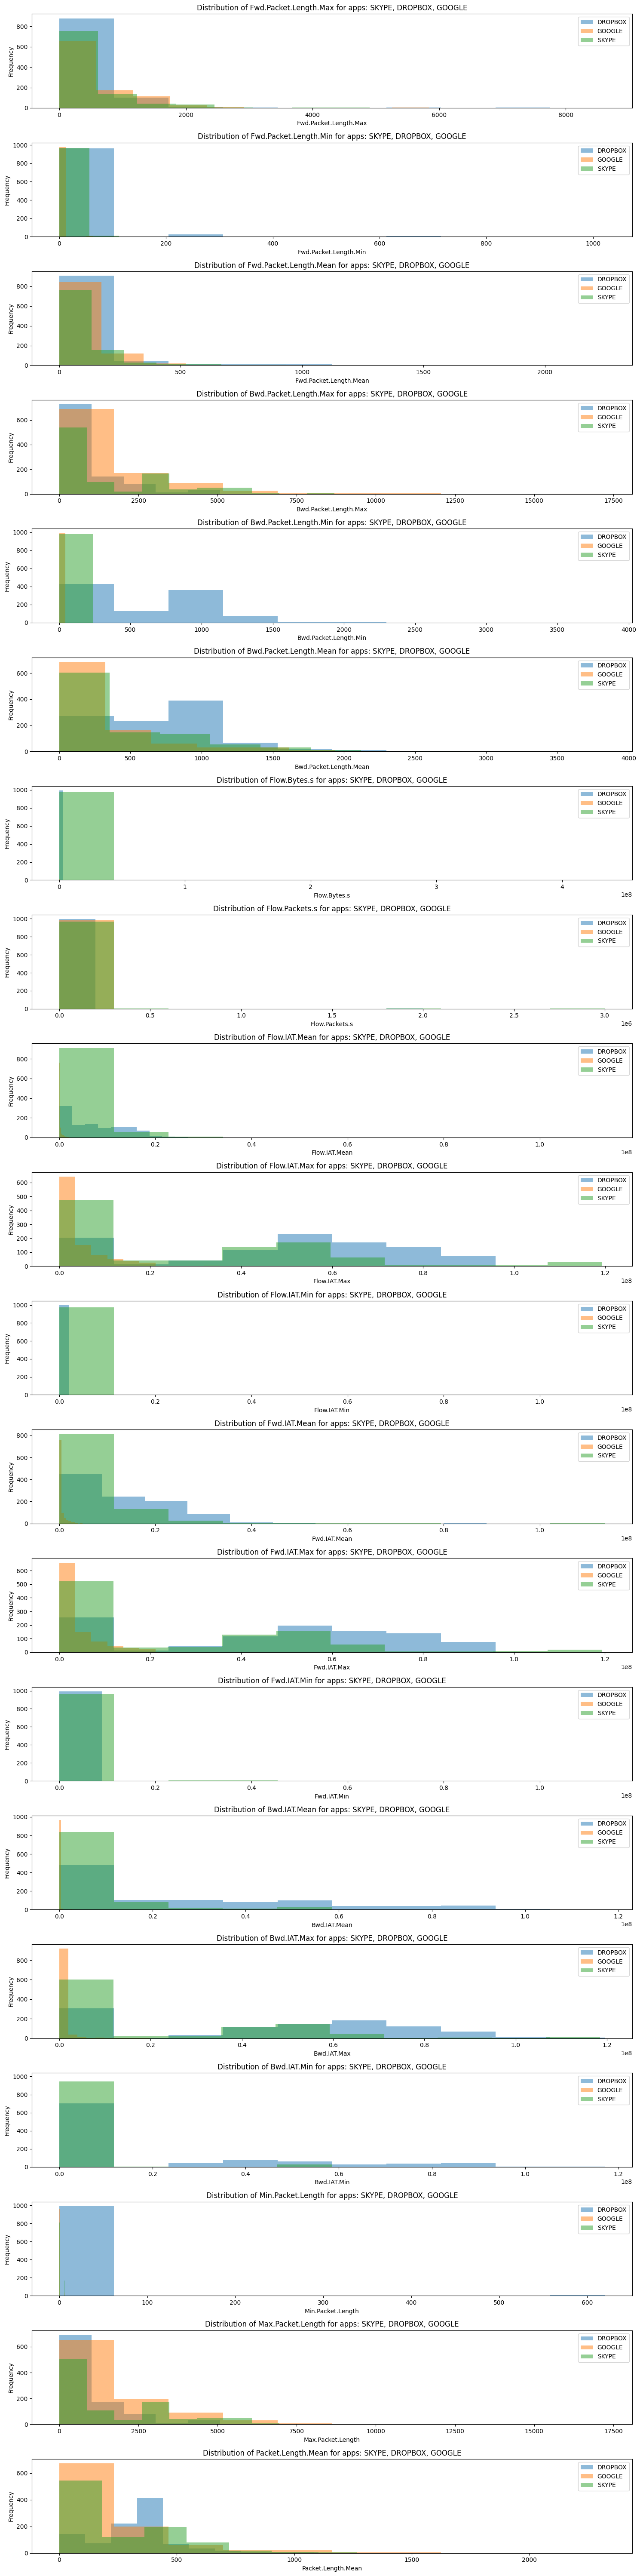

In [5]:
apps = ['SKYPE', 'DROPBOX', 'GOOGLE']
plot_feature_distribution(apps)


**3**.
**Dataset** **loading**

The cleaned dataset is loaded, and application names are converted to numerical labels using a consistent mapping. The feature matrix (X) and the label vector (y) are returned for use in machine learning models. A stratified 80/20 train-test split is applied to ensure the class distribution is preserved across both sets, which is critical for balanced performance evaluation.



In [6]:
def load_dataset(app_names):
    # Inputs: - app_names: list of app names (e.g., ['SKYPE', 'DROPBOX', 'GOOGLE'])
    # Outputs: - X: feature matrix (np.ndarray)
    #          - y: label vector (np.ndarray with 0, 1, 2)

    filename = 'Features/apps_flow_dataset_' + '_'.join(app_names) + '.csv'
    feature_df = pd.read_csv(filename)

    # Assign numeric labels (e.g., SKYPE → 0, DROPBOX → 1, GOOGLE → 2)
    label_mapping = {app: i for i, app in enumerate(app_names)}
    feature_df['Label'] = feature_df['Label'].map(label_mapping)

    X = feature_df.drop(columns=['Label']).to_numpy()
    y = feature_df['Label'].to_numpy()

    return X, y, label_mapping


In [7]:
X, y, label_mapping = load_dataset(apps)

print(" Feature matrix shape:", X.shape)
print("Label vector shape:", y.shape)

# Train/test split with stratified sampling to preserve label balance
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Check consistency of label distribution
print(" # samples per class in y:", np.bincount(y))
print(" # samples per class in y_train:", np.bincount(y_train))
print(" # samples per class in y_test:", np.bincount(y_test))


 Feature matrix shape: (2970, 20)
Label vector shape: (2970,)
 # samples per class in y: [981 998 991]
 # samples per class in y_train: [785 798 793]
 # samples per class in y_test: [196 200 198]


**4**.
**Hyperparametersoptimization** **and** **model** **training**

This section involves a 5-fold cross-validation procedure to identify the optimal regularization parameter (C) and the maximum number of iterations for a multinomial logistic regression classifier. After selecting the best hyperparameters, the model is retrained on the full training set and evaluated in terms of training accuracy and computational time.

Logistic Regression with Standardized Features:

Feature standardization is applied to the training and test data to normalize the input values (zero mean and unit variance). The logistic regression training process is repeated on the standardized data to assess the impact of feature scaling on model performance.

XGBoost – Hyperparameter Optimization:

An extensive grid search with 5-fold cross-validation is conducted to optimize the XGBoost classifier. Parameters such as the number of estimators, maximum tree depth, and subsample rate are tuned to maximize classification accuracy. The optimal model is then retrained using the entire training set.

Final XGBoost Model Training:

Using the best hyperparameters identified in Task 4c, the XGBoost model is trained on the non-standardized training data. Model performance metrics and training duration are recorded for comparison with the logistic regression models.






In [8]:
def train_classifier_logistic(X_train, y_train, resfilelogistic):
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import KFold
    import time
    import matplotlib.pyplot as plt
    import numpy as np
    import os

    n_split_kfold = 5
    skf = KFold(n_splits=n_split_kfold, shuffle=True, random_state=42)

    best_params = {'regularization': 0, 'max_iter': 0, 'score': 0}
    C_reg_range = [1, 10, 100, 1000]
    maxit_range = [1000, 5000, 10000]
    scoreplot = np.zeros((len(C_reg_range), len(maxit_range)))

    t0 = time.time()
    for i, C_reg in enumerate(C_reg_range):
        for j, maxit in enumerate(maxit_range):
            print(f'Testing hyperparameters: regularization: {C_reg}, max_iter: {maxit}')
            score = 0
            for train_index, test_index in skf.split(X_train, y_train):
                X_fold_train, X_fold_test = X_train[train_index], X_train[test_index]
                y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]

                #  Multiclass logistic regression
                logisticRegr = LogisticRegression(C=C_reg, max_iter=maxit, multi_class='multinomial', solver='lbfgs', random_state=42)
                logisticRegr.fit(X_fold_train, y_fold_train)
                score += logisticRegr.score(X_fold_test, y_fold_test)

            score /= n_split_kfold
            scoreplot[i, j] = score
            if score > best_params['score']:
                best_params.update({'regularization': C_reg, 'max_iter': maxit, 'score': score})

    t1 = time.time()
    crossval_time = round(t1 - t0, 3)
    print('Crossval time [s]:', crossval_time)
    print('Best hyperparams during crossval:', best_params)
    print(scoreplot)

    for p in range(scoreplot.shape[1]):
        plt.plot(C_reg_range, scoreplot[:, p], label=f'maxiter={maxit_range[p]}')
    plt.xlabel("Regularization parameter C")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    #  Retrain on full training set with best parameters
    bestlogisticRegr = LogisticRegression(
        C=best_params['regularization'],
        max_iter=best_params['max_iter'],
        multi_class='multinomial',
        solver='lbfgs',
        random_state=42
    )

    t0 = time.time()
    bestlogisticRegr.fit(X_train, y_train)
    t1 = time.time()
    training_time = round(t1 - t0, 3)
    finalscore = bestlogisticRegr.score(X_train, y_train)
    print('Final model score:', finalscore)
    print('Training time [s]:', training_time)

    # Write results to file
    with open(resfilelogistic, 'w') as result_file:
        result_file.write('*** LOGISTIC REGRESSION ***\n')
        result_file.write('*** Crossvalidation results ***\n')
        result_file.write(f"Best C: {best_params['regularization']}\n")
        result_file.write(f"Best number of iterations: {best_params['max_iter']}\n")
        result_file.write(f"Best crossvalidation accuracy: {best_params['score']}\n\n")
        result_file.write('*** Best model results (retrained with entire training set) ***\n')
        result_file.write(f"Accuracy: {finalscore}\n")
        result_file.write(f"Training duration [s]: {training_time}\n")

    return bestlogisticRegr, best_params


Testing hyperparameters: regularization: 1, max_iter: 1000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'mul

Testing hyperparameters: regularization: 1, max_iter: 5000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of

Testing hyperparameters: regularization: 1, max_iter: 10000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of

Testing hyperparameters: regularization: 10, max_iter: 1000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of

Testing hyperparameters: regularization: 10, max_iter: 5000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of

Testing hyperparameters: regularization: 10, max_iter: 10000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of

Testing hyperparameters: regularization: 100, max_iter: 1000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of

Testing hyperparameters: regularization: 100, max_iter: 5000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of

Testing hyperparameters: regularization: 100, max_iter: 10000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of

Testing hyperparameters: regularization: 1000, max_iter: 1000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of

Testing hyperparameters: regularization: 1000, max_iter: 5000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of

Testing hyperparameters: regularization: 1000, max_iter: 10000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of

Crossval time [s]: 324.626
Best hyperparams during crossval: {'regularization': 10, 'max_iter': 10000, 'score': 0.6102644847412649}
[[0.47727554 0.57153737 0.60478815]
 [0.47643255 0.57870146 0.61026448]
 [0.47895002 0.58586112 0.6031172 ]
 [0.474751   0.57786201 0.5997364 ]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


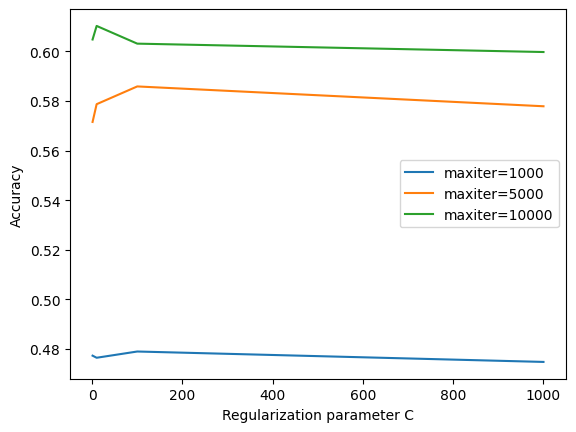

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Final model score: 0.6106902356902357
Training time [s]: 12.239


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
res_folder = 'Results'
os.makedirs(res_folder, exist_ok=True)
resf = res_folder + '/testlogregr_results.txt'

logreg_model, best_params_logreg = train_classifier_logistic(X_train, y_train, resf)


Standardized Feature Shapes:
X_train_std: (2376, 20)
y_train: (2376,)
X_test_std: (594, 20)
y_test: (594,)
Testing hyperparameters: regularization: 1, max_iter: 1000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Testing hyperparameters: regularization: 1, max_iter: 5000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Testing hyperparameters: regularization: 1, max_iter: 10000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Testing hyperparameters: regularization: 10, max_iter: 1000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Testing hyperparameters: regularization: 10, max_iter: 5000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Testing hyperparameters: regularization: 10, max_iter: 10000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Testing hyperparameters: regularization: 100, max_iter: 1000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Testing hyperparameters: regularization: 100, max_iter: 5000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Testing hyperparameters: regularization: 100, max_iter: 10000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Testing hyperparameters: regularization: 1000, max_iter: 1000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Testing hyperparameters: regularization: 1000, max_iter: 5000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Testing hyperparameters: regularization: 1000, max_iter: 10000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Crossval time [s]: 15.151
Best hyperparams during crossval: {'regularization': 1000, 'max_iter': 1000, 'score': 0.7584139761167624}
[[0.73820964 0.73820964 0.73820964]
 [0.75125874 0.75125874 0.75125874]
 [0.75588943 0.75588943 0.75588943]
 [0.75841398 0.75841398 0.75841398]]


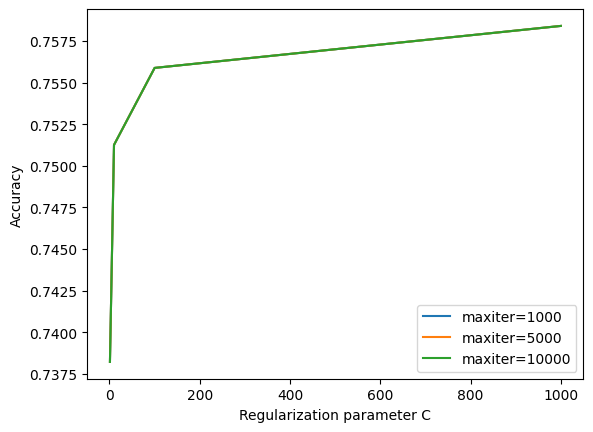

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Final model score: 0.7685185185185185
Training time [s]: 0.27


In [10]:
# --- Standardize the feature data ---
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

print("Standardized Feature Shapes:")
print("X_train_std:", X_train_std.shape)
print("y_train:", y_train.shape)
print("X_test_std:", X_test_std.shape)
print("y_test:", y_test.shape)

# --- Train logistic regression with standardized data ---
res_folder = 'Results'
os.makedirs(res_folder, exist_ok=True)

resf = res_folder + '/testlogregr_results_STD.txt'
logreg_std, best_params_logreg_std = train_classifier_logistic(X_train_std, y_train, resf)


In [11]:
def train_classifier_XGB(X_train, y_train, resfileXGB):
    from sklearn.model_selection import KFold
    from xgboost import XGBClassifier
    import numpy as np
    import matplotlib.pyplot as plt
    import time
    import os

    n_split_kfold = 5
    skf = KFold(n_splits=n_split_kfold, shuffle=True, random_state=42)

    best_params = {'n_estimators': 0, 'max_depth': 0, 'subsample': 0, 'score': 0}
    num_estimators_range = [25, 50, 100]
    max_depth_range = [5, 20, 50]
    subsample_range = [0.7, 0.9, 1]

    scoreplot = np.zeros((len(num_estimators_range), len(max_depth_range), len(subsample_range)))

    t0 = time.time()
    for i, n_est in enumerate(num_estimators_range):
        for j, max_dep in enumerate(max_depth_range):
            for k, subsamp in enumerate(subsample_range):
                print(f'Testing: n_estimators={n_est}, max_depth={max_dep}, subsample={subsamp}')
                score = 0
                for train_index, test_index in skf.split(X_train, y_train):
                    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
                    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

                    xgb = XGBClassifier(
                        verbosity=0,
                        objective='multi:softprob',
                        eval_metric='mlogloss',
                        num_class=3,  #  for 3-class
                        n_estimators=n_est,
                        max_depth=max_dep,
                        subsample=subsamp
                    )

                    xgb.fit(X_train_fold, y_train_fold)
                    score += xgb.score(X_test_fold, y_test_fold)

                score /= n_split_kfold
                scoreplot[i, j, k] = score

                if score > best_params['score']:
                    best_params.update({
                        'score': score,
                        'n_estimators': n_est,
                        'max_depth': max_dep,
                        'subsample': subsamp
                    })

    t1 = time.time()
    print(' Crossval time [s]:', round(t1 - t0, 3))
    print(' Best hyperparameters:', best_params)

    # Plot accuracy trends
    for p in range(scoreplot.shape[0]):
        for q in range(scoreplot.shape[1]):
            plt.plot(subsample_range, scoreplot[p, q, :], label=f'n_est={num_estimators_range[p]} max_dep={max_depth_range[q]}')
    plt.xlabel("Subsample")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    # --- Retrain with best parameters ---
    bestxgb = XGBClassifier(
        verbosity=0,
        objective='multi:softprob',
        eval_metric='mlogloss',
        num_class=3,
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        subsample=best_params['subsample']
    )

    t0 = time.time()
    bestxgb.fit(X_train, y_train)
    t1 = time.time()
    training_time = round(t1 - t0, 3)
    finalscore = bestxgb.score(X_train, y_train)

    print(f' Final training accuracy: {finalscore}')
    print(f' Training time [s]: {training_time}')

    # Save results to file
    with open(resfileXGB, 'w') as result_file:
        result_file.write('*** XGBoost Classifier ***\n')
        result_file.write('*** Crossvalidation results ***\n')
        result_file.write(f"Best n_estimators: {best_params['n_estimators']}\n")
        result_file.write(f"Best max_depth: {best_params['max_depth']}\n")
        result_file.write(f"Best subsample: {best_params['subsample']}\n")
        result_file.write(f"Best crossvalidation accuracy: {best_params['score']}\n\n")
        result_file.write('*** Final model results ***\n')
        result_file.write(f"Accuracy: {finalscore}\n")
        result_file.write(f"Training duration [s]: {training_time}\n")

    return bestxgb, best_params


Testing: n_estimators=25, max_depth=5, subsample=0.7
Testing: n_estimators=25, max_depth=5, subsample=0.9
Testing: n_estimators=25, max_depth=5, subsample=1
Testing: n_estimators=25, max_depth=20, subsample=0.7
Testing: n_estimators=25, max_depth=20, subsample=0.9
Testing: n_estimators=25, max_depth=20, subsample=1
Testing: n_estimators=25, max_depth=50, subsample=0.7
Testing: n_estimators=25, max_depth=50, subsample=0.9
Testing: n_estimators=25, max_depth=50, subsample=1
Testing: n_estimators=50, max_depth=5, subsample=0.7
Testing: n_estimators=50, max_depth=5, subsample=0.9
Testing: n_estimators=50, max_depth=5, subsample=1
Testing: n_estimators=50, max_depth=20, subsample=0.7
Testing: n_estimators=50, max_depth=20, subsample=0.9
Testing: n_estimators=50, max_depth=20, subsample=1
Testing: n_estimators=50, max_depth=50, subsample=0.7
Testing: n_estimators=50, max_depth=50, subsample=0.9
Testing: n_estimators=50, max_depth=50, subsample=1
Testing: n_estimators=100, max_depth=5, subsam

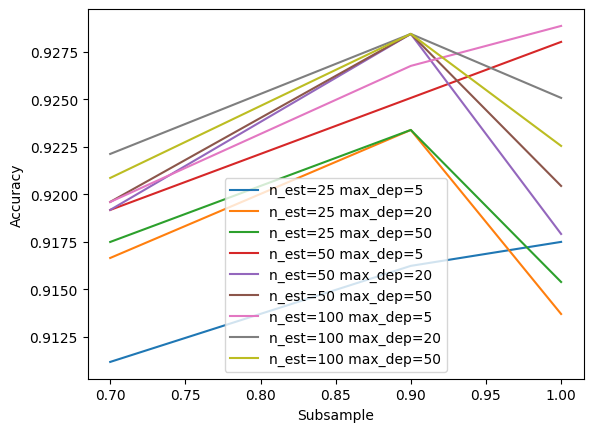

 Final training accuracy: 0.9949494949494949
 Training time [s]: 0.501


In [12]:
resf = res_folder + '/testXGB_results.txt'
XGB_model, best_params_XGB = train_classifier_XGB(X_train, y_train, resf)


**5**.
**Testing** **and** **performance** **evaluation**

A comprehensive evaluation function is defined to compute standard classification metrics including accuracy, precision, recall, and F1-score, both per class and in a global weighted average. Confusion matrices (absolute and normalized) are also computed, visualized, and saved for each model to provide insight into classification effectiveness and error distribution.

Prediction and Model Comparison


The logistic regression model (trained on standardized data) and the XGBoost model (trained on raw data) are applied to the test set. Their respective predictions are evaluated using the performance evaluation function. Results are saved and presented to facilitate model comparison.

In [13]:
def performance_eval(y_true, y_pred, lab, l_names, resfile):
    import numpy as np
    import matplotlib.pyplot as plt
    import sklearn.metrics as mt
    from sklearn.metrics import confusion_matrix

    # --- Compute metrics ---
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision = mt.precision_score(y_true, y_pred, labels=lab, average=None)
    global_precision = mt.precision_score(y_true, y_pred, labels=lab, average='weighted')
    recall = mt.recall_score(y_true, y_pred, labels=lab, average=None)
    global_recall = mt.recall_score(y_true, y_pred, labels=lab, average='weighted')
    f1score = mt.f1_score(y_true, y_pred, labels=lab, average=None)
    global_f1score = mt.f1_score(y_true, y_pred, labels=lab, average='weighted')

    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # --- Write results to file ---
    with open(resfile, 'w') as result_file:
        result_file.write('Results for the TEST SET\n')
        result_file.write(f'Accuracy: {accuracy}\n')
        result_file.write(f'Precision per class: {precision}\n')
        result_file.write(f'Global Precision: {global_precision}\n')
        result_file.write(f'Recall per class: {recall}\n')
        result_file.write(f'Global Recall: {global_recall}\n')
        result_file.write(f'F1-score per class: {f1score}\n')
        result_file.write(f'Global F1-score: {global_f1score}\n\n')

        result_file.write('Confusion matrix (absolute)\n')
        np.savetxt(result_file, cm, fmt='%.2f')
        result_file.write('\nConfusion matrix (normalized)\n')
        result_file.write(str(cm_norm))

    # --- Plot absolute confusion matrix ---
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(lab)), yticks=np.arange(len(lab)),
           xticklabels=l_names, yticklabels=l_names,
           title='Confusion matrix', ylabel='True label', xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig(resfile.replace('.txt', '_conf_matrix.png'))
    plt.show()

    # --- Plot normalized confusion matrix ---
    fig_n, ax_n = plt.subplots()
    im_n = ax_n.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
    ax_n.figure.colorbar(im_n, ax=ax_n)
    ax_n.set(xticks=np.arange(len(lab)), yticks=np.arange(len(lab)),
             xticklabels=l_names, yticklabels=l_names,
             title='Normalized Confusion Matrix', ylabel='True label', xlabel='Predicted label')
    plt.setp(ax_n.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax_n.text(j, i, format(cm_norm[i, j], '.2f'), ha="center", va="center",
                      color="white" if cm_norm[i, j] > thresh else "black")
    fig_n.tight_layout()
    fig_n.savefig(resfile.replace('.txt', '_conf_matrix_normalized.png'))
    plt.show()

    return accuracy, global_precision, global_recall, global_f1score


************** LOGISTIC REGRESSION **************


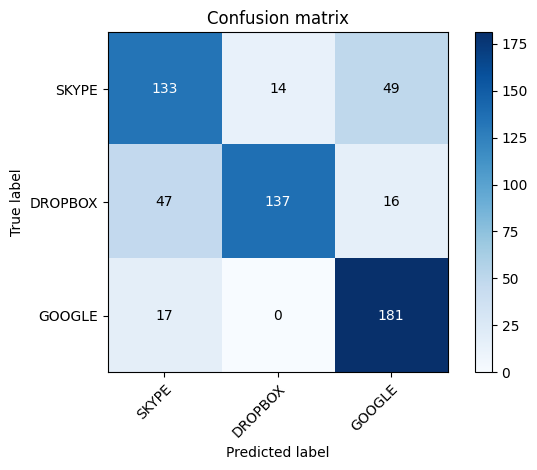

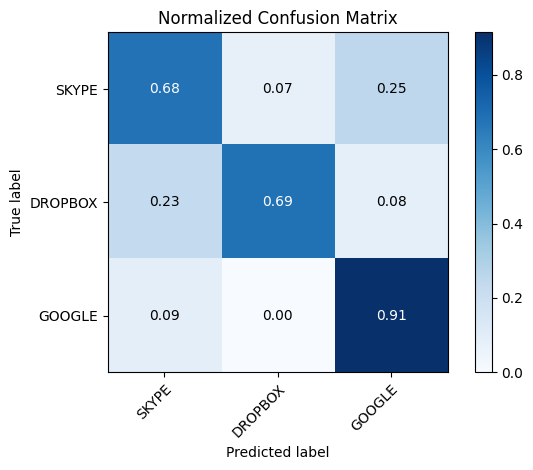

Logistic regression metrics (accuracy, precision, recall, f1score): (0.7592592592592593, 0.7735096861415809, 0.7592592592592593, 0.7579450608854057)
**************************************************


************** XGBOOST **************


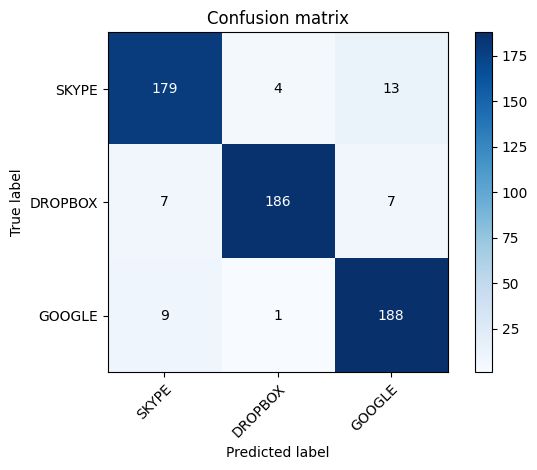

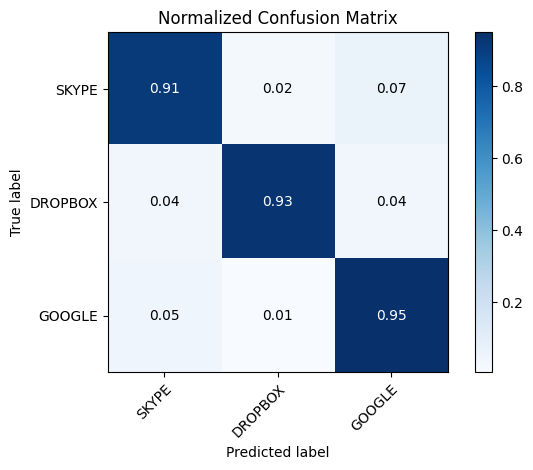

XGB metrics (accuracy, precision, recall, f1score): (0.930976430976431, 0.9320604126014248, 0.930976430976431, 0.9311592400048172)


In [14]:
# --- Multiclass label definitions ---
lbl = [0, 1, 2]  # Integer labels
label_names = apps  # Human-readable app names (e.g. ['SKYPE', 'DROPBOX', 'GOOGLE'])

# --- Output file paths ---
restestfilelogreg = res_folder + '/logreg_test_results.txt'
restestfileXGB = res_folder + '/XGB_test_results.txt'

# --- Make predictions on test set ---
y_pred_logreg = logreg_std.predict(X_test_std)
y_pred_XGB = XGB_model.predict(X_test)

# --- Evaluate logistic regression model ---
print('************** LOGISTIC REGRESSION **************')
logreg_metrics = performance_eval(y_test, y_pred_logreg, lbl, label_names, restestfilelogreg)
print('Logistic regression metrics (accuracy, precision, recall, f1score):', logreg_metrics)
print('**************************************************\n\n')

# --- Evaluate XGBoost model ---
print('************** XGBOOST **************')
XGB_metrics = performance_eval(y_test, y_pred_XGB, lbl, label_names, restestfileXGB)
print('XGB metrics (accuracy, precision, recall, f1score):', XGB_metrics)


**PCA-Based Visualization of Feature Space**

Principal Component Analysis (PCA) is used to project the high-dimensional feature space into two dimensions for visualization. The transformed data points are plotted with class labels to visually inspect the separation among traffic flows corresponding to different applications. This step provides intuitive insight into the structure of the data and the difficulty of the classification task.



--------------------
Original shape: (2970, 20)
PCA-transformed shape: (2970, 2)


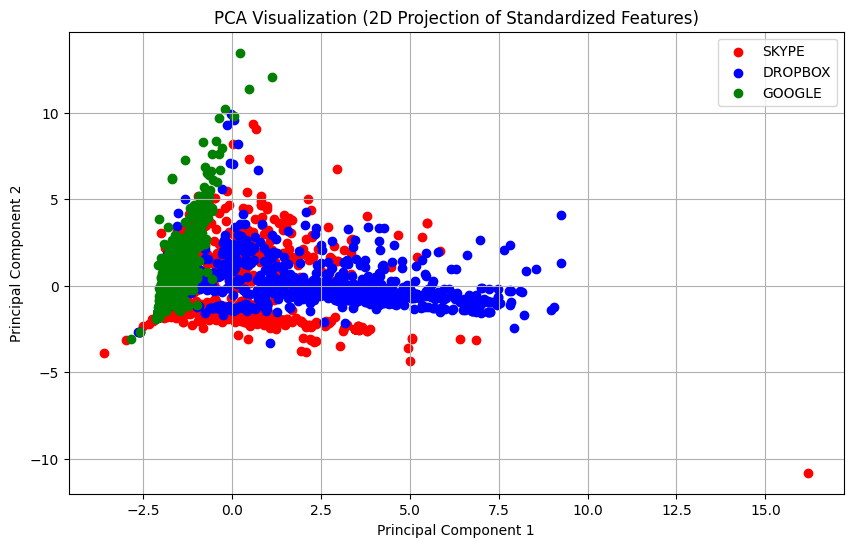

In [15]:
from sklearn.decomposition import PCA

# Standardize all features
X_std = scaler.fit_transform(X)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_new = pca.fit_transform(X_std)

print('--------------------')
print("Original shape:", X.shape)
print("PCA-transformed shape:", X_new.shape)

# Plot all classes
plt.figure(figsize=(10, 6))
unique_labels = np.unique(y)

colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan']  # Extend if more apps
scatter_handles = []

for idx, label in enumerate(unique_labels):
    class_points = X_new[y == label]
    scatter = plt.scatter(class_points[:, 0], class_points[:, 1], c=colors[idx % len(colors)], label=apps[label])
    scatter_handles.append(scatter)

plt.legend(handles=scatter_handles, loc='best')
plt.title('PCA Visualization (2D Projection of Standardized Features)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()
